<a href="https://colab.research.google.com/github/Khaled-Mohammed-Abdelgaber/deep-learning-projects-/blob/main/variational_autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing required libraries and modules
we will use keras to implement variational autoencoder 
we need the following layers from keras.layers:
* **Conv2D**: well known why.
* **Conv2DTranspose**: needed in upscaling and downscaling
* **Flatten**: to flate the output of last convolution layer before going to Desne layer
* **Dense**: to process the feature to get laten feature vectore  
* **Lambda**: used to make mathmatic operations to the output of neural layers after feeding it to following layers
* **Reshape**: used to reshape the output of convolution layers


In [29]:
!pip install tensorflow==1.13.2
!pip install q keras==2.0.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.7 MB 39 kB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 367 kB 75.7 MB/s 
     |████████████████████████████████| 3.2 MB 41.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently tak

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 4.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [1]:
import keras 
import tensorflow as tf
from keras.layers import * 
from keras.models import Model
from keras.datasets import mnist
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint #to save checkpoints
import numpy as np 
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
#first to mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading datasets and preprocessing 

In [3]:
(X_train , y_train) ,(X_test , y_test) = mnist.load_data()

In [4]:
type(X_train[0,0,0])

numpy.uint8

In [5]:
X_train = X_train.astype('float32') # we convert training data from int to float so that we can normalize it to values from 0 to 1
X_test = X_test.astype('float32')
#note if train and test input was int as in their original case when we divide it to 255 to normalize it, the result will be zero or 1 
#so that the first step to convert them to float
X_train = X_train/255.0
X_test = X_test/255.0

In [6]:
type(X_train[0,0,0])

numpy.float32

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
#we need to reshape the datasets to (num_of_datasets,height,width,num_channel) because Conv2D deal with 3D tensor only if not an error will appear 
#the model accept images in sequence and first dimention which is 60000 in case of train will not considered as a dimention 
#in original case the mnist image shape is (28,28) we will convert it to (28,28,1)
train_datasets_num = X_train.shape[0]
img_height = X_train.shape[2]
img_width = X_train.shape[1]
num_channels = 1 #since mnist is grey images
test_datasets_num = X_test.shape[0]


X_train = X_train.reshape(train_datasets_num,img_height,img_width,num_channels)
X_test = X_test.reshape(test_datasets_num,img_height,img_width,num_channels)

input_shape = (img_height , img_width , num_channels) #represent the shape model will accept each time

X_train.shape , X_test.shape , input_shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (28, 28, 1))

# Displaying some images of datasets

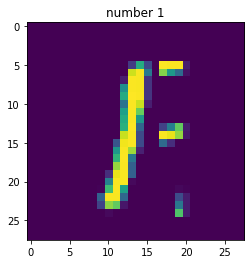

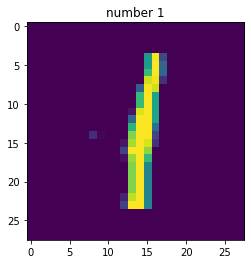

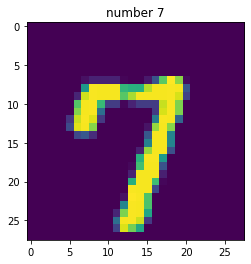

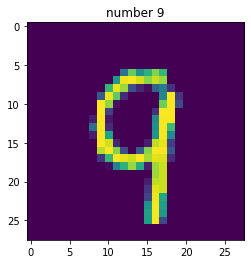

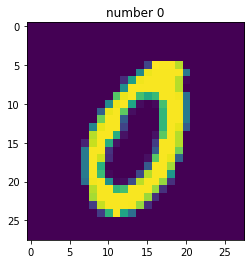

In [9]:
for i in np.random.randint(0 , 60000 , 5):
  plt.figure()
  plt.imshow(X_train[i][:,:,0]) #note that imshow accept 2D not 3D so that we need to specify the channel
  plt.title("number " + str(y_train[i]))

# Building model 


we can not use sequential model since variational autoencoder is not sequential for all layers in bottleneck there are mean and variance.
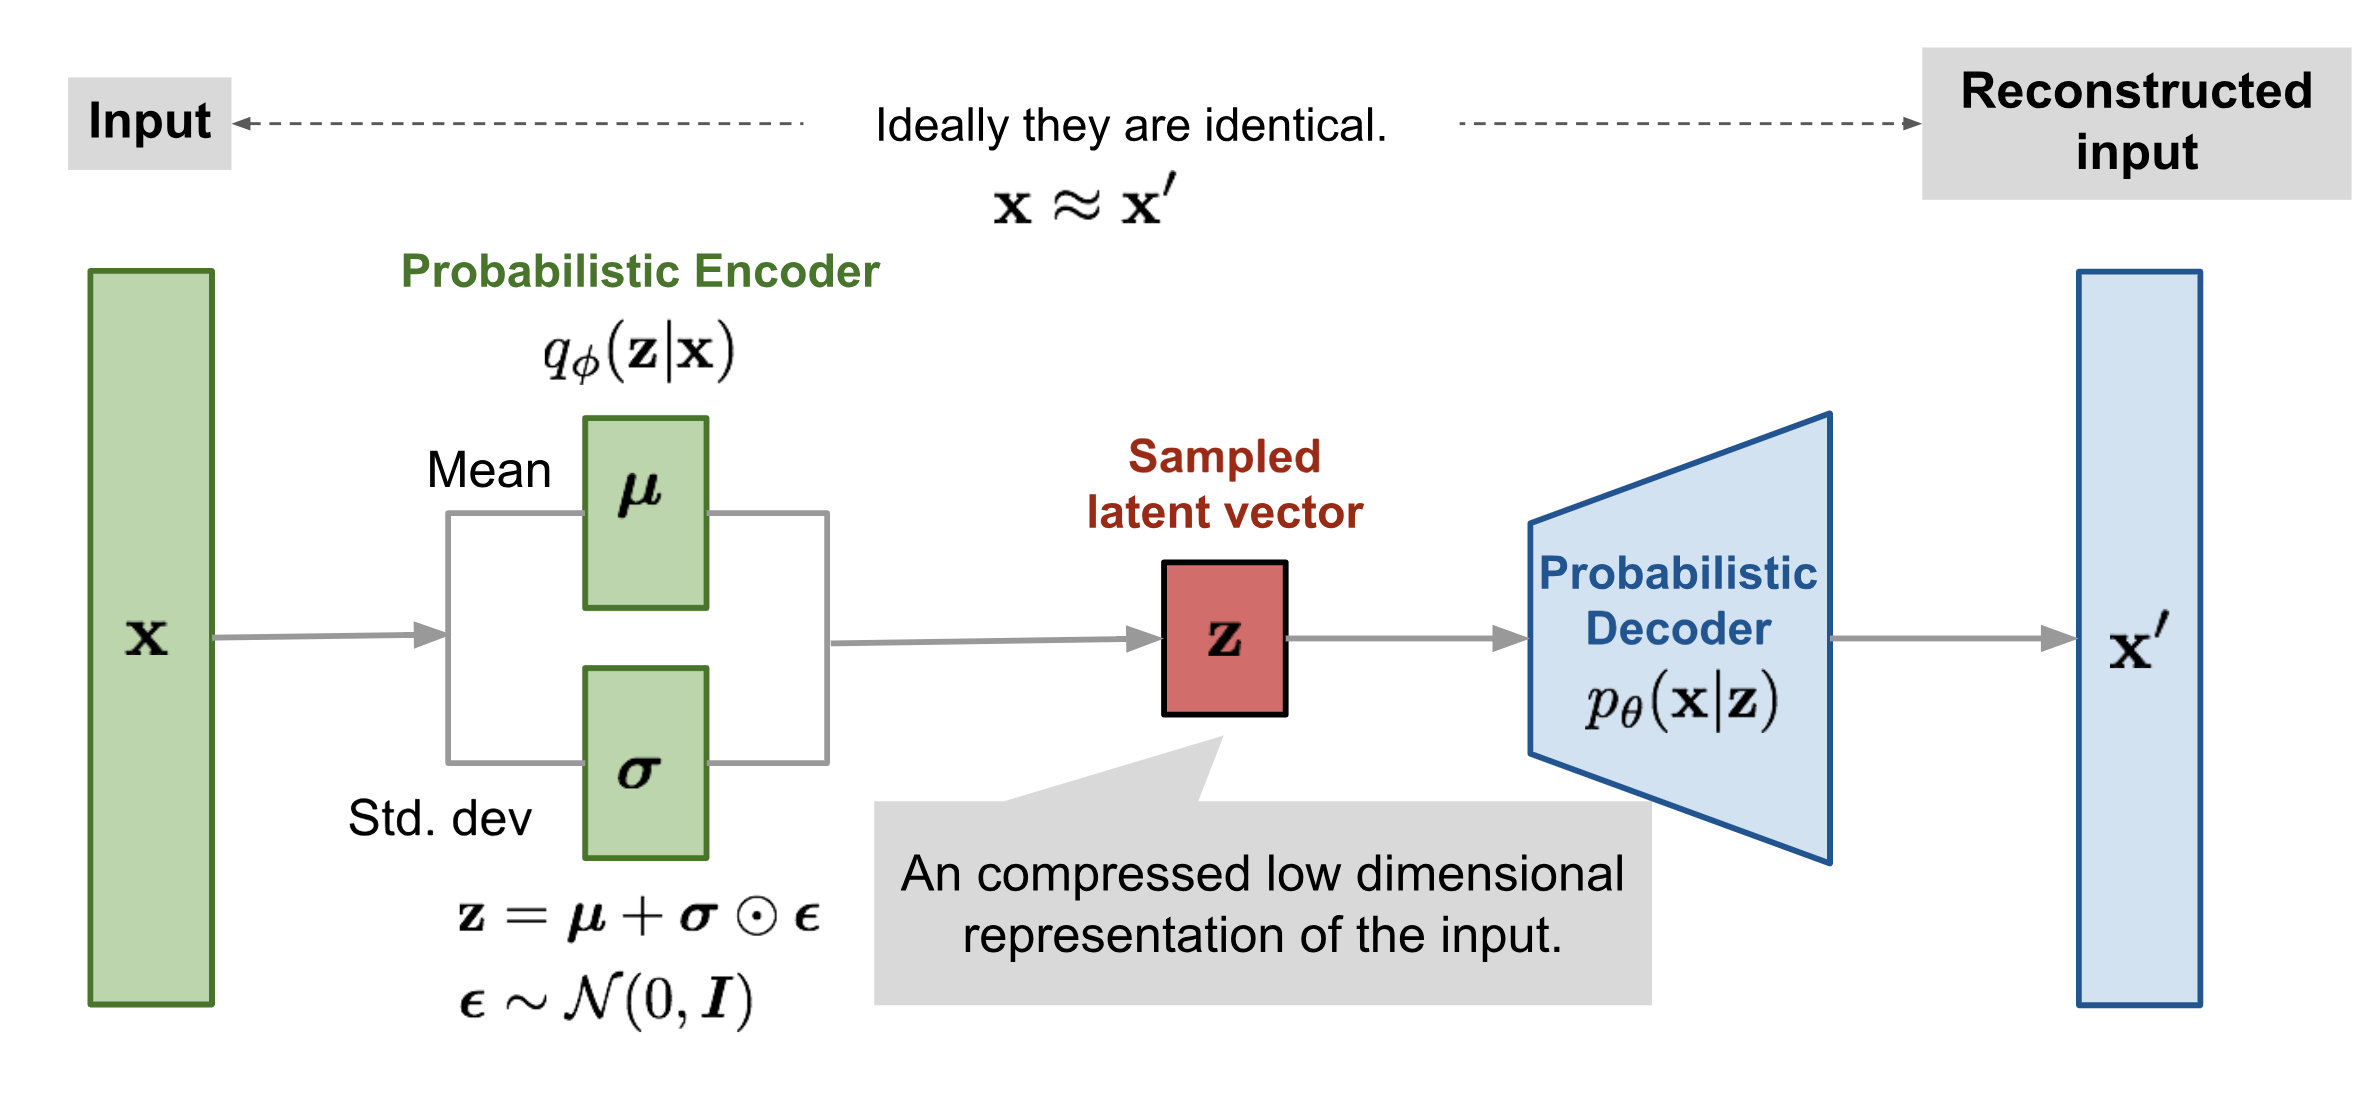

##Encoder part

In [10]:
laten_dim = 2 #this represent number of dimension or components to which each image will incoded
input_img = Input(shape = input_shape , name = 'encoder_input') #just instantiate a Keras tensor.
x = Conv2D(32,3,activation = 'relu',padding = 'same')(input_img)#32 filter each of size 3 * 3 
x = Conv2D(64,3,activation = 'relu',padding = 'same',strides=(2,2))(x)
x = Conv2D(64 , 3 , activation = 'relu',padding  = 'same')(x)  #64 filter each of size 3*3 and activation is relu
x = Conv2D(64 , 3 , activation = 'relu',padding  = 'same')(x)

#we need to store the shape of features before conv2D layers which will be used latter in reshapping
conv_shape = K.int_shape(x) #Returns the shape of tensor or variable as a tuple of int or None entries
print('conv output shape is ',conv_shape)
x = Flatten()(x) 
x = Dense(32 , activation = 'relu')(x)

mu = Dense(laten_dim , name = 'laten_mean')(x)
sigma = Dense(laten_dim , name = 'laten_variance')(x)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


conv output shape is  (None, 14, 14, 64)


In [11]:
K.int_shape(mu)[1] ,K.shape(mu)[0]

(2, <tf.Tensor 'strided_slice:0' shape=() dtype=int32>)

## sampling function
there are a lot of math of which i do not care about for more information you can visit [this tutorial](https://www.borealisai.com/research-blogs/tutorial-5-variational-auto-encoders/) 

In [12]:
def sampling(args):
  z_mu,z_sigma = args
   
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma /2) * eps

In [13]:
z = Lambda(sampling , output_shape=(laten_dim,),name = 'Z')([mu,sigma])
encoder = Model(input_img , [mu ,sigma , z], name = 'encoder_output')
encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         encoder_input[0][0]              
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(encoder,show_shapes=True ,to_file='Encoder.png')

##Decoder part
first i want to take about Reshape layer and Conv2DTranspose layer 
* **Reshape layer:** used to reshape the output of previouse layer no any thing else. it is non-trainable layer. we can say that flatten is special case of reshape layer.
* **Conv2DTranspose:** is reverse process of convolution (Deconvolution)
we need this layer to upsample (trainable upsampling)
* **note that:** 
  * **UpSampling2D** is just a simple scaling up of the image by using nearest neighbour or bilinear upsampling, so nothing smart. Advantage is it's cheap.
just repeating in special sequence.
  * **Conv2DTranspose** is a convolution operation whose kernel is learnt (just like normal conv2d operation) while training your model. Using Conv2DTranspose will also upsample its input but the key difference is the model should learn what is the best upsampling for the job.[source](https://stackoverflow.com/questions/53654310/what-is-the-difference-between-upsampling2d-and-conv2dtranspose-functions-in-ker)
  * in Conv2DTranspose we make traditional convolution and upsampling. the main factor that affect on the size of output of Conv2DTranspose is strides value. 
  if strides is one shape will be equal to input shape.



In [22]:
decoder_input = Input(shape = (laten_dim ,) , name = 'decoder_input')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3],activation='relu')(decoder_input)
x = Reshape((conv_shape[1] , conv_shape[2] , conv_shape[3]))(x)#we can say that flatten is special case of reshape
x = Conv2DTranspose(32,2,padding = 'same',strides = (2,2) , activation = 'relu')(x)
x = Conv2DTranspose(32,2,padding = 'same', activation = 'relu')(x)
#more layers will improve the output upto overfitting
x = Conv2DTranspose(num_channels , 2 , padding = 'same',activation = 'sigmoid',name = 'decoder_output')(x) #this layer no stides added so strides = 1 
decoder = Model(decoder_input , x , name = 'decoder')

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_3 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        8224      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 32)        4128      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         129       
Total params: 50,113
Trainable params: 50,113
Non-trainable params: 0
_________________________________________________________________


In [23]:
plot_model(decoder,show_shapes=True ,to_file='Decoder.png')

# Note on autoencoder loss function:
**Reconstruction Loss:** The loss function we use to train the autoencoder is highly dependent on the type of input and output we want the autoencoder to adapt to. If we are working with image data, the most popular loss functions for reconstruction are MSE Loss and L1 Loss. In case the inputs and outputs  are within the range [0,1], as in MNIST, we can also make use of Binary Cross Entropy as the reconstruction loss.[source](https://www.v7labs.com/blog/autoencoders-guide)


In [24]:
z_decoded = decoder(z) #apply decoder laten sample
class CustomLayer(keras.layers.Layer):
  def vae_loss(self , x , z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)


    re_loss = keras.metrics.binary_crossentropy(x,z_decoded)
    kl_loss = -5e-4 * K.mean(1+sigma - K.square(mu)-K.exp(sigma),axis = -1)
    return K.mean(re_loss + kl_loss)
  
  def call(self,inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x,z_decoded)
    self.add_loss(loss,inputs = inputs)
    return x

In [25]:
z_decoded

<tf.Tensor 'decoder_1/decoder_output/Sigmoid:0' shape=(?, ?, ?, 1) dtype=float32>

In [26]:
# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img , z_decoded])

In [27]:
y

<tf.Tensor 'custom_layer_1/Identity:0' shape=(?, 28, 28, 1) dtype=float32>

In [28]:
VAE = Model(input_img , y, name = 'vae')
VAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         encoder_input[0][0]              
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

In [38]:
cp= ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/VAE',save_best_only= True) #make check point

In [39]:
plot_model(VAE,show_shapes=True ,to_file='/content/drive/MyDrive/Colab Notebooks/VAE/VAE.png')

In [40]:
VAE.compile(optimizer = 'adam' , loss = None)
VAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         encoder_input[0][0]              
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Output "custom_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_layer_1" during training.
  """Entry point for launching an IPython kernel.


In [41]:
type(X_train)

numpy.ndarray

In [43]:
history = VAE.fit(X_train ,None , epochs = 10 , batch_size = 32 , validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 300s - loss: 0.1905 - val_loss: 0.1897
Epoch 2/10
48000/48000 [==============================] - 301s - loss: 0.1886 - val_loss: 0.1885
Epoch 3/10
48000/48000 [==============================] - 298s - loss: 0.1871 - val_loss: 0.1869
Epoch 4/10
48000/48000 [==============================] - 300s - loss: 0.1861 - val_loss: 0.1863
Epoch 5/10
48000/48000 [==============================] - 299s - loss: 0.1852 - val_loss: 0.1856
Epoch 6/10
48000/48000 [==============================] - 299s - loss: 0.1844 - val_loss: 0.1848
Epoch 7/10
48000/48000 [==============================] - 296s - loss: 0.1838 - val_loss: 0.1852
Epoch 8/10
48000/48000 [==============================] - 295s - loss: 0.1832 - val_loss: 0.1843
Epoch 9/10
48000/48000 [==============================] - 297s - loss: 0.1827 - val_loss: 0.1846
Epoch 10/10
48000/48000 [==============================] - 301s - loss: 0.182

In [44]:
VAE.save("/content/drive/MyDrive/Colab Notebooks/VAE/VAE.h5")

In [47]:
pred = VAE.predict(X_test)

In [48]:
pred.shape , X_test.shape

((10000, 28, 28, 1), (10000, 28, 28, 1))

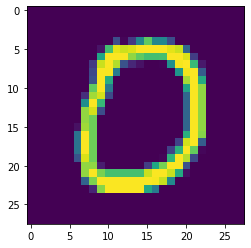

In [52]:
plt.figure()
plt.imshow(pred[10,:,:,0])

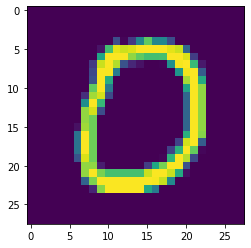

In [53]:
plt.figure()
plt.imshow(X_test[10,:,:,0])